# How to use GAN 

## 개요

### 학습 전제

* Convolution의 padding, stride 등의 기본 개념을 알고 있다.
* 교차 엔트로피(Cross Entropy) 등의 손실 함수, 최적화 함수 등 딥러닝의 기본적인 학습 알고리즘을 알고 있다.
* 텐서플로우를 활용해 신경망을 학습시키는 코드를 다뤄본 적이 있다.
* 간단한 판별 모델링(분류, 회귀 등)의 개념을 알고, 실습해 본 적이 있다.

### 학습 목표

* 생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기
* Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기
* Fashion MNIST 데이터셋의 의미를 알기
* 생성적 적대 신경망(GAN)의 구조와 원리를 이해하기
* 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기

### 목차

1. 없던 데이터를 만들어낸다, 생성 모델링
2. 여러 가지 생성 모델링 기법과 친해지기
3. 패션을 디자인하려면? 먼저 패션을 배워야지!
4. 그림을 만들어내는 화가 생성자(Generator), 그리고 평가하는 비평가 구분자(Discriminator)
5. 생성 모델이 똑똑해지기 위한 기나긴 여정

## 생성 모델링 설명

* 판별 모델링 (Discriminative Modeling) : 입력받은 데이터를 어떤 기준에 대해 판별하는 것이 목표인 모델링
* 생성 모델링 (Generative Modeling) : 없던 데이터를 생성하는 것이 목표인 모델링

생성 모델링의 2가지 부분
* 생성자 (Generator) : 새로운 데이터를 만들어내는 자
* 판별자 또는 구분자 (Discriminator) : 생성자가 만들어낸 데이터를 판별 또는 구분하는 자

GAN은 강화학습이라 보기엔 그렇고 비지도학습(속이려는자)과 라벨을 가진 판단자가 섞인 준지도학습 정도로 볼 수 있다.

## 여러가지 생성 모델링 기법

### Pix2Pix

* 간단한 이미지를 실제 사진처럼 보이게 해줄 때 사용되는 모델.
* 단순화된 이미지(Input Image)와 실제 이미지(Ground Truth) 쌍으로 이루어진 데이터셋으로 학습을 진행
* Input Image를 기반으로 새로운 Predicted Image를 출력.
* 한 이미지를 다른 이미지로 픽셀 단위로 변환한다는 뜻으로 Pixel to Pixel = Pix2Pix 이름이 되었습니다.

### CycleGAN

* 한 이미지와 다른 이미지를 번갈아가며 Cyclic하게 변환 가능합니다.
* 한 방향 변환인 Pix2Pix와 달리 CycleGAN은 양방향 변환입니다.
* 단순이미지와 실제이미지 쌍이 필요했던 Pix2Pix와 달리 CycleGAN은 쌍이 필요없습니다.
* 라벨이 필요없다!
* 사진을 그림으로 또는 그림을 사진으로 만들기

### Neural Style Transfer

* 신경망 기술을 사용하여 이미지의 스타일을 변환 시킴.
* Base Image 와 Style Image 2장을 활용해 새로운 이미지를 만들어내는 것.
* Base Image의 내용은 잃지 않으면서 Style Image 을 효과적으로 입히기 위한 정교한 손실함수들이 짜여있다.

## 패션 디자인

### Fashion MNIST

* [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) : 손글씨 데이터인 MNIST와 아주 비슷한 형태의 데이터셋.
* 기존의 MNIST가 너무 쉽고 너무 많이 사용되었으며 최신 CV 작업에 맞지 않다고 하여 만듬.
* 크기 : 28x28
* train : 6만, test : 1만
* 카테고리 : 10개(옷 종류)

### 코드

#### Load Modules

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

print("tensorflow", tf.__version__)

tensorflow 2.9.1


#### Data 불러오기

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


#### 전처리

* (-1, 1)로 정규화합니다.

In [4]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

* 채널수 추가
* shape[0] = 60000

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

#### 출력해보기

* 하나만 출력해봅시다.
* colorbar를 통해 픽셀값에 따른 색을 알 수 있습니다.
* [cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

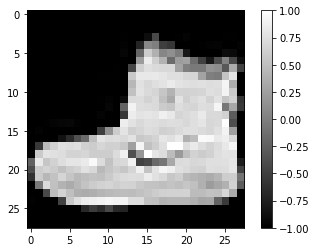

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
# plt.imshow(train_x[0].reshape(28, 28), cmap='rainbow')
plt.colorbar()
plt.show()

* row와 col을 받아서 랜덤한 이미지를 출력하는 함수를 만들어봅시다.

In [8]:
def show_image(row =2, col = 5, img_list = train_x):
    total = row * col
    rand_idx = []
    fig, axes = plt.subplots(row, col, figsize = (col*3,row*3))
    axes = axes.flatten()

    for i in range(total):
        rand_idx.append(np.random.randint(0,50000))

    for idx, value in enumerate(rand_idx):
        axes[idx].imshow(img_list[value], cmap = 'gray')
        axes[idx].set_title('Index' + str(value))
        axes[idx].axis('off')

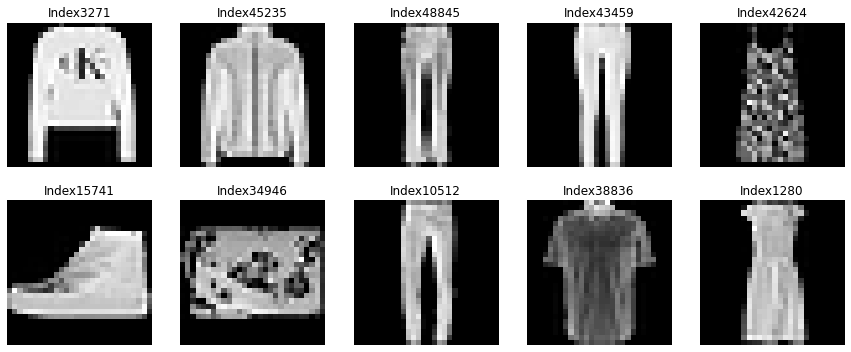

In [9]:
show_image(2,5)

#### Dataset 준비

* 전체를 섞기 위해 BUFFER_SIZE를 6만으로 설정
* BATCH_SIZE : 모델이 한번에 학습할 양
* 이렇게 전체를 한번에 학습하는 것이 아닌 나눠서 학습하는 것을 미니 배치 학습이라고 합니다.

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-08-28 17:08:07.016879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-28 17:08:08.176622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6413 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## GAN 이해하기

GAN(Generative Adversarial Network)
* 생성자(Generator) : 아무 의미없는 랜덤 노이즈로부터 신경망에서 연산을 통해 이미지 형상의 벡터를 생성
* 판별자(Discriminator) : 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지 Fake인지를 판단하는 실숫값을 출력

<img src = 'data/GAN_1.png' width = '50%' height = '50%'>

## 생성자 구현하기

DCGAN 구현해보기

* 단계 모델을 생성합니다.
* Dense layer를 추가합니다 : 출력이 7,7,256 이고 편항을 없애고 받는 데이터는 (100,) 형태입니다.
* [BatchNormalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)를 추가합니다 : input을(가중치) 정규화합니다.(default : 평균을 0으로 표준편차는 1인 방향으로)
* LeakyReLU를 추가합니다.
* Reshape : 형태를 재생성
* [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) : Transposed convolution layer
  - Conv2D와 반대로 이미지 사이즈를 넓혀주는 층.
  - Convolution 과 반대로 사이즈가 커진다.
  - Convolution의 outputsize : (i + 2p - k)/s + 1 (i : input, p : padding, k : kernel size, s : stride)
  - ConvTranspose outputsize : (n + 2p - k)/s + 1 = i 에서 n값이므로  (i-1)*s + k - 2p
  - stride 값에 따라 커널이 움직이는 거리가 증가하는게 아니라 input 값과 input 값 사이에 패딩을 넣어준다.
* 마지막은 tanh

In [11]:
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

* Leaky ReLU

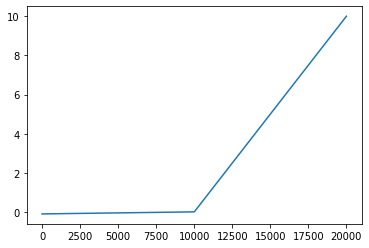

In [12]:
def Leaky_ReLU(x):
    return np.maximum(0.01*x, x)

x = np.arange(-10.0,10.0, 0.1**3)
plt.plot(Leaky_ReLU(x))

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

* 노이즈 벡터 만들기

In [14]:
noise = tf.random.normal([1, 100])

* 간단한 결과 이미지 만들기
* 단, 학습 중이 아니니 training=False

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

2022-08-28 17:08:11.602887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


TensorShape([1, 28, 28, 1])

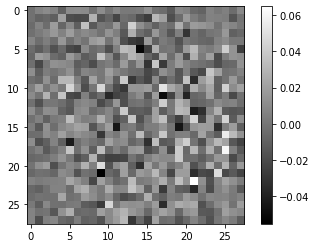

In [16]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## 판별자 구현하기

* Pooling이 아닌 Convolution strides를 통해 크기를 줄여주었다.
* Dropout : 신경망의 0.3을 사용하지 않겠다 -> 오버피팅 방지  
  test 때는 Dropout을 사용하지않는다.

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

* 결과 확인

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00072432]], dtype=float32)>

## 손실 함수

### loss function

* 교차 엔트로피(Cross Entropy)
* Real_Image의 라벨을 1, Fake_Image의 라벨을 0
* 생성자 : D(fake_image) 1에 가까워지게
* 판별자 : D(real_image) 1에 가까워지게, D(fake_image)는 0에 가까워지게

* 제한이 없는 기존의 H 보다 BinaryCrossentropy의 Input은 0 ~ 1 사이의 확률값으로 가정
* from_logits = True 해줘야 0 ~ 1 값으로 정규화해서(sigmoid 사용) 계산함

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
* real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
* 두 값을 1 또는 0에 비교해야하므로 tf.ones_like(), tf.zeros_like() 함수 활용
* 두 함수는 값이 1 또는 0으로 가득 채워진 벡터를 만들때 사용

In [21]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

### generator loss

* fake_output이 1에 가까워지길 바람
* tf.ones_like 와 교차 엔트로피 계산
* cross_entropy(tf.ones_like(fake_output), fake_output)은 fake_output이 1에 가까울수록 작아짐

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss

* real_output이 1에 가까워지기를, fake_output은 0에 가까워지기를 바람.
* 2개의 loss 계산해서 둘을 더함

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

* 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산
* 둘다 1.0에 가깝다면 판별자가 진짜도 잘 구분하고 가짜도 잘 구분한다는 뜻 - 생성자가 일을 잘 못한다.
* 일단 가짜에 대한 accuracy가 0.5에 가까워지는 것은 당연하다. 우리의 최종목적이므로
* 그런데 진짜도 accuracy가 0.5에 가까워지는 것은 결국 모델이 학습하게 되는 input data가 생성자한테 받는거니  
  가짜를 구분 잘 못하게 된다는것은 진짜를 가짜라고도 말하게 되는거기 때문에 둘다 0.5로 가는게 이상적

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 최적화 함수

* Adam을 사용합니다.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

* (16,100) 벡터의 노이즈 생성

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 설계

### Decorator

* 하나의 미니 배치 당 진행 할 train_step 함수를 먼저 만들어야 합니다.
* 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용합니다.
* 직접 session을 열어서 학습했다가 완료시 다시 닫아주는 번거로운 과정을 내부적으로 처리함 

In [27]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [28]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

* f(x,y)의 결과 타입은 다릅니다.
* @tf.function 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환

1. images : Real Image가 들어올 입력 데이터
2. 생성자가 FAKE IMAGE를 생성하기 위한 noise 를 image 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성
3. 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 열기
4. 입력받은 noise로 generated images 생성
5. 판별자가 Real Image 인 images와 Fake Image 인 generated_images 각각 입력 받은 후 real_output, fake_output 출력
6. loss : fake_output, real_ouput으로 생성자, 판별자의 loss 계산
7. accuracy : fake_output, real_ouput으로 판별자 정확도 계산
8. gradient : gen_tape, disc_tape를 활용해 gradient 자동으로 계산
9. 모델학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
10. 리턴값 : 이번 스텝에 계산된 loss, accuracy 리턴

In [29]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

* 이렇게 한번의 train_step이 끝납니다.
* 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 봅시다.
* 고정된 seed를 통해 만들어내므로 고정 seed에 대한 결과물이 얼마나 나아지는지 확인할 수 있습니다.

In [30]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    plt.savefig('generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

* loss, accuracy 또한 확인해야 합니다.
* train_step이 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장

In [31]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

* tf.train.Checkpoint를 활용해 매번 모델을 직접 저장하지 않아도 코드 한 줄로 빠르고 편하게 관리 가능.
* checkpoint에는 optimizer 생성자, 판별자 모두 넣어 저장합니다.(정확히는 학습한 모델의 가중치) 

In [32]:
checkpoint_dir = 'training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 모델 학습

### 모델 학습

* train_step : 한 단계 학습
* generate_and_save_images() : 샘플 이미지 생성 및 저장
* draw_train_history() : 학습과정 시각화
* checkpoint : 모델 저장

In [33]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

* save_every : 모델을 저장하는 간격
* EPOCHS : 전체 학습 Epoch

In [34]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

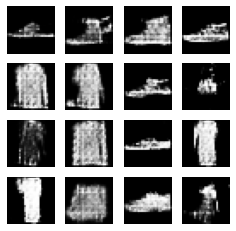

Time for training : 632 sec


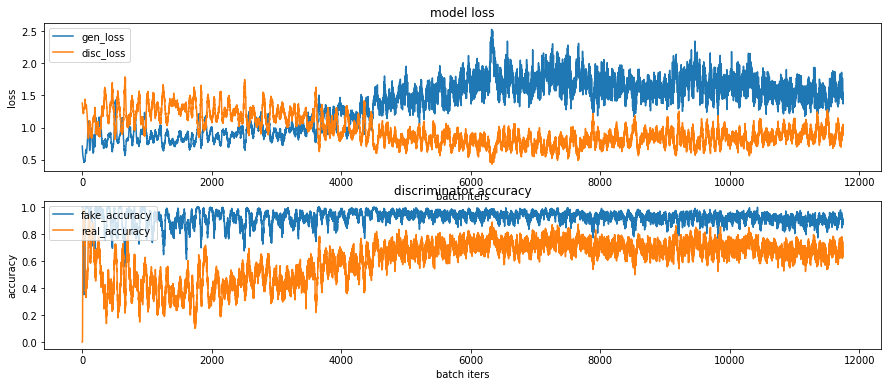

CPU times: user 7min 4s, sys: 1min 13s, total: 8min 17s
Wall time: 10min 33s


In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 학습과정 시각화

* GIF는 imageio로 만들 수 있다.
* imagio.get_writer를 활용해 파일을 열고 거기에 append_data 로 이미지를 하나씩 붙이는 방식

In [36]:
anim_file = 'data/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /home/aiffel/Code/Exploration_Practice/11/data/fashion_mnist_dcgan.gif

/tmp/ipykernel_28573/4182011239.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


-rw-rw-r-- 1 aiffel aiffel 1066893  8월 28 17:18 /home/aiffel/Code/Exploration_Practice/11/data/fashion_mnist_dcgan.gif


/tmp/ipykernel_28573/4182011239.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
